# Machine Learning 2  
Lab Practice: Online Learning  
Course 2025-2026  
Students: Azaliia Agisheva, Jose Manuel Bueno Tabernero


# Problem Definition

## Informal Problem Statement

The goal is to build a weather prediction system that continuously updates as new hourly weather records arrive from many cities. In practical terms, we want a model that can keep making useful temperature predictions over time even as weather patterns naturally change across seasons and regions.

Instead of building one model per city, we use one shared model that learns from all cities together.

In [1]:
# M1: Problem definition declarations
problem_definition = {
    "task_type": "regression",
    "target_variable": "temperature",
    "global_model": True,
    "global_model_description": "One model trained on all cities, with city used as an input feature."
}

problem_definition

{'task_type': 'regression',
 'target_variable': 'temperature',
 'global_model': True,
 'global_model_description': 'One model trained on all cities, with city used as an input feature.'}

## ML Task and Global Scope

This project is a **supervised regression** task. The model predicts a continuous numeric value (temperature), which makes regression the correct formulation.

### Global Model Scope (All Cities Together)

- A single global model is trained with records from all locations.
- The `city` field is treated as a categorical feature so the model can learn location-specific behavior while sharing knowledge across cities.
- This setup is intentionally more realistic for streaming systems that aggregate data from multiple sources.

In [2]:
# Why concept drift is expected in this project
concept_drift_expectation = {
    "seasonal_variation": "Weather relationships change across months and seasons.",
    "geographic_variation": "Different cities/climates follow different local weather dynamics.",
    "streaming_context": "Data arrives over long periods, so old patterns may become less representative."
}

concept_drift_expectation

{'seasonal_variation': 'Weather relationships change across months and seasons.',
 'geographic_variation': 'Different cities/climates follow different local weather dynamics.',
 'streaming_context': 'Data arrives over long periods, so old patterns may become less representative.'}

## Why Concept Drift Is Expected

Concept drift is expected for two main reasons:

1. **Seasonal changes:** the relationship between predictors (humidity, pressure, wind, etc.) and temperature shifts through the year.
2. **Geographic diversity:** cities in different regions have different climate regimes, and their behavior over time is not stationary.

Because the system processes a long chronological stream, these shifts should appear in model error trends and drift detector signals.

In [3]:
# Evaluation metrics for regression and their purpose
metrics_plan = {
    "MAE": "Mean Absolute Error; easy to interpret average absolute error in temperature units.",
    "RMSE": "Root Mean Squared Error; penalizes large errors more strongly than MAE.",
    "R2": "Coefficient of Determination; indicates explained variance relative to a baseline mean predictor."
}

metrics_plan

{'MAE': 'Mean Absolute Error; easy to interpret average absolute error in temperature units.',
 'RMSE': 'Root Mean Squared Error; penalizes large errors more strongly than MAE.',
 'R2': 'Coefficient of Determination; indicates explained variance relative to a baseline mean predictor.'}

## Evaluation Metrics and Justification

- **MAE** is used because it gives a direct, human-readable average prediction error magnitude.
- **RMSE** is used because it emphasizes larger mistakes, which are important in forecasting scenarios.
- **R2** is used to summarize how much variance is explained by the model compared with a naive baseline.

Using all three gives balanced performance interpretation: general error level (MAE), large-error sensitivity (RMSE), and explained variance (R2).

In [4]:
# Explicit assumptions for Milestone M1
assumptions = [
    "Data points are processed in chronological order to mimic real-time arrival.",
    "The same global model is trained across all cities; city is included as an input feature.",
    "Temperature prediction is treated as a regression problem.",
    "Performance is assessed with MAE, RMSE, and R2 throughout the project.",
    "Concept drift may arise from seasonal changes and geographic heterogeneity."
]

for i, item in enumerate(assumptions, start=1):
    print(f"A{i}. {item}")

A1. Data points are processed in chronological order to mimic real-time arrival.
A2. The same global model is trained across all cities; city is included as an input feature.
A3. Temperature prediction is treated as a regression problem.
A4. Performance is assessed with MAE, RMSE, and R2 throughout the project.
A5. Concept drift may arise from seasonal changes and geographic heterogeneity.


# Dataset Justification

## Source and Files Used

This project uses the **Historical Hourly Weather Data** dataset from Kaggle:

- Source: https://www.kaggle.com/selfishgene/historical-hourly-weather-data
- Files used in this notebook:
  - `city_attributes.csv`
  - `humidity.csv`
  - `pressure.csv`
  - `temperature.csv`
  - `weather_description.csv`
  - `wind_direction.csv`
  - `wind_speed.csv`

## Why This Dataset Fits Stream Learning

- It has a clear timestamp (`datetime`) with hourly observations over multiple years.
- Data can be processed in chronological order, which matches real-time stream simulation.
- The long time span and multi-city setup make distribution shifts likely, which is ideal for concept drift analysis.

## Why Wide -> Long Is Required

The weather files are in **wide format** (one column per city). Stream learning and global modeling require each observation to be a single row with explicit keys, so we transform to **long format**:

- from: `datetime, city_1, city_2, ...`
- to: `datetime, city, value`

This makes merging variables and sequential processing straightforward.

In [5]:
# M2: Dataset inspection setup
from pathlib import Path
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 50)

DATA_DIR = Path("data")

file_map = {
    "humidity": DATA_DIR / "humidity.csv",
    "pressure": DATA_DIR / "pressure.csv",
    "temperature": DATA_DIR / "temperature.csv",
    "weather_description": DATA_DIR / "weather_description.csv",
    "wind_direction": DATA_DIR / "wind_direction.csv",
    "wind_speed": DATA_DIR / "wind_speed.csv",
    "city_attributes": DATA_DIR / "city_attributes.csv",
}

files_status = pd.DataFrame(
    {
        "file": [k for k in file_map],
        "path": [str(v) for v in file_map.values()],
        "exists": [v.exists() for v in file_map.values()],
    }
)

files_status

,file,path,exists
0,humidity,data\humidity.csv,True
1,pressure,data\pressure.csv,True
2,temperature,data\temperature.csv,True
3,weather_description,data\weather_description.csv,True
4,wind_direction,data\wind_direction.csv,True
5,wind_speed,data\wind_speed.csv,True
6,city_attributes,data\city_attributes.csv,True


## Temporal Coverage, Number of Cities, and Key Variables

The next cell reports the required dataset diagnostics:

- date range
- number of cities
- key variables used in modeling

These checks make the data scope explicit before preprocessing.

In [6]:
# Required M2 summary: date range, number of cities, key variables
city_attributes = pd.read_csv(file_map["city_attributes"])
city_count = city_attributes["City"].nunique()

temperature_dt = pd.read_csv(file_map["temperature"], usecols=["datetime"], parse_dates=["datetime"])
date_min = temperature_dt["datetime"].min()
date_max = temperature_dt["datetime"].max()

key_variables = [
    "humidity",
    "pressure",
    "temperature",
    "weather_description",
    "wind_direction",
    "wind_speed",
    "city",
    "country",
    "latitude",
    "longitude",
]

dataset_report = pd.DataFrame(
    {
        "item": [
            "date_range_start",
            "date_range_end",
            "number_of_cities",
            "key_variables_used",
        ],
        "value": [
            str(date_min),
            str(date_max),
            int(city_count),
            ", ".join(key_variables),
        ],
    }
)

dataset_report

,item,value
0,date_range_start,2012-10-01 12:00:00
1,date_range_end,2017-11-30 00:00:00
2,number_of_cities,36
3,key_variables_used,"humidity, pressure, temperature, weather_descr..."


## Initial Missingness Summary

The following summary is computed directly from the original wide-format weather files.

- **Per-variable missingness** is calculated across all city columns.
- **Overall missingness (%)** is computed across all variable-value cells combined (excluding `datetime`).

In [7]:
# M2 missingness summary (per variable + overall)
weather_variables = [
    "humidity",
    "pressure",
    "temperature",
    "weather_description",
    "wind_direction",
    "wind_speed",
]

missing_rows = []
overall_missing = 0
overall_total = 0

for var in weather_variables:
    df_var = pd.read_csv(file_map[var])
    value_df = df_var.drop(columns=["datetime"])

    total_values = int(value_df.size)
    missing_values = int(value_df.isna().sum().sum())
    missing_pct = (missing_values / total_values) * 100 if total_values else 0.0

    missing_rows.append(
        {
            "variable": var,
            "total_values": total_values,
            "missing_values": missing_values,
            "missing_pct": round(missing_pct, 4),
        }
    )

    overall_total += total_values
    overall_missing += missing_values

missingness_summary = pd.DataFrame(missing_rows).sort_values("missing_pct", ascending=False)
overall_missing_pct = (overall_missing / overall_total) * 100 if overall_total else 0.0

print(f"Overall missingness (%): {overall_missing_pct:.4f}")
missingness_summary

Overall missingness (%): 0.7907


,variable,total_values,missing_values,missing_pct
0,humidity,1629108,28651,1.7587
1,pressure,1629108,16680,1.0239
2,temperature,1629108,8030,0.4929
5,wind_speed,1629108,7993,0.4906
4,wind_direction,1629108,7975,0.4895
3,weather_description,1629108,7955,0.4883


# Data Preparation

This section implements the full preprocessing pipeline required for M3 inside this notebook:

1. wide -> long for each weather file
2. merge on (`datetime`, `city`)
3. join city attributes
4. missing-value handling (forward-fill by city, drop unresolved target NaN)
5. Kelvin -> Celsius conversion
6. chronological sorting for stream simulation
7. temporal feature creation
8. cyclical encodings
9. rare category grouping for `weather_description`
10. final dataset validation

In [8]:
# M3 step 1: melt weather files from wide to long
from functools import reduce

def melt_wide_csv(filepath: Path, value_name: str) -> pd.DataFrame:
    df = pd.read_csv(filepath, parse_dates=["datetime"])
    return df.melt(id_vars="datetime", var_name="city", value_name=value_name)

long_tables = {
    var: melt_wide_csv(file_map[var], var)
    for var in [
        "humidity",
        "pressure",
        "temperature",
        "weather_description",
        "wind_direction",
        "wind_speed",
    ]
}

# quick preview of one melted table
long_tables["temperature"].head()

,datetime,city,temperature
0,2012-10-01 12:00:00,Vancouver,NaN
1,2012-10-01 13:00:00,Vancouver,284.630000
2,2012-10-01 14:00:00,Vancouver,284.629041
3,2012-10-01 15:00:00,Vancouver,284.626998
4,2012-10-01 16:00:00,Vancouver,284.624955


## Merge Long Tables and Join City Attributes

All long tables are merged on the shared keys `datetime` and `city`, then enriched with geographic metadata from `city_attributes.csv`.

In [9]:
# M3 steps 2-3: merge all long weather tables and join city attributes
merged_weather = reduce(
    lambda left, right: left.merge(right, on=["datetime", "city"], how="outer"),
    long_tables.values(),
)

city_attributes_clean = city_attributes.rename(columns={"City": "city", "Country": "country"})
prepared_df = merged_weather.merge(
    city_attributes_clean[["city", "country", "Latitude", "Longitude"]]
        .rename(columns={"Latitude": "latitude", "Longitude": "longitude"}),
    on="city",
    how="left",
)

prepared_df.head()

,datetime,city,humidity,pressure,temperature,weather_description,wind_direction,wind_speed,country,latitude,longitude
0,2012-10-01 12:00:00,Albuquerque,NaN,NaN,NaN,NaN,NaN,NaN,United States,35.084492,-106.651138
1,2012-10-01 12:00:00,Atlanta,NaN,NaN,NaN,NaN,NaN,NaN,United States,33.749001,-84.387978
2,2012-10-01 12:00:00,Beersheba,NaN,NaN,NaN,NaN,NaN,NaN,Israel,31.251810,34.791302
3,2012-10-01 12:00:00,Boston,NaN,NaN,NaN,NaN,NaN,NaN,United States,42.358429,-71.059769
4,2012-10-01 12:00:00,Charlotte,NaN,NaN,NaN,NaN,NaN,NaN,United States,35.227089,-80.843132


## Temperature Target Imputation (Stream-Safe) and Chronological Sort

We first convert temperature from Kelvin to Celsius, then impute missing **temperature** (target) in a way that is safe for online/stream evaluation.

**Why this is stream-safe**

- **City-wise LOCF (Last Observation Carried Forward):** For each city we sort by `datetime` and forward-fill only the `temperature` column using the last observed value. No future values are used, so there is no leakage and the same logic could be applied in a real-time stream.

**Why we drop leading NaNs**

- The first observations per city have no prior value to carry forward; after LOCF those rows still have NaN. We drop them so the target has no missing values and downstream models/evaluation never see NaN targets.

In [10]:
# M3 steps 4-6: Kelvin -> Celsius, then temperature-only LOCF, drop leading NaNs, sort for stream

# 1. Kelvin -> Celsius first (only if values look like Kelvin)
if prepared_df["temperature"].max() > 200:
    prepared_df["temperature_c"] = prepared_df["temperature"] - 273.15
    prepared_df = prepared_df.drop(columns=["temperature"]).rename(columns={"temperature_c": "temperature"})

# 2. NaN count before LOCF (for validation)
nan_before_locf = int(prepared_df["temperature"].isna().sum())

# 3. Sort by city, then datetime for per-city forward fill
prepared_df = prepared_df.sort_values(["city", "datetime"]).reset_index(drop=True)

# 4. City-wise LOCF for temperature only (stream-safe: no future values)
prepared_df["temperature"] = (
    prepared_df.groupby("city", group_keys=False)["temperature"]
    .apply(lambda s: s.ffill())
)

# 5. NaN count after LOCF, and rows to drop (for validation)
nan_after_locf = int(prepared_df["temperature"].isna().sum())
rows_with_nan_after_locf = prepared_df[prepared_df["temperature"].isna()]
n_rows_before_drop = len(prepared_df)
dropped_per_city = rows_with_nan_after_locf.groupby("city").size().sort_values(ascending=False)
total_rows_dropped = len(rows_with_nan_after_locf)

# 6. Drop rows where temperature is still NaN (leading NaNs per city)
prepared_df = prepared_df.dropna(subset=["temperature"]).copy()

# 7. Sort for stream simulation
prepared_df = prepared_df.sort_values(["datetime", "city"]).reset_index(drop=True)

prepared_df[["datetime", "city", "temperature"]].head()

,datetime,city,temperature
0,2012-10-01 12:00:00,Eilat,35.95
1,2012-10-01 13:00:00,Albuquerque,11.97
2,2012-10-01 13:00:00,Atlanta,20.88
3,2012-10-01 13:00:00,Beersheba,34.44
4,2012-10-01 13:00:00,Boston,14.02


## Validation: temperature imputation

Below we report NaN counts before/after LOCF, total rows dropped, top 10 cities by number of dropped rows, and confirm that the final `temperature` column has no missing values.

In [11]:
# Temperature imputation validation
print("NaN in temperature before LOCF:", nan_before_locf)
print("NaN in temperature after LOCF (before drop):", nan_after_locf)
print("Total rows dropped (leading NaNs):", total_rows_dropped)
print("\nTop 10 cities by number of dropped rows:")
display(dropped_per_city.head(10).to_frame(name="rows_dropped"))

print("\nFinal check: NaN count in temperature =", prepared_df["temperature"].isna().sum())
assert prepared_df["temperature"].isna().sum() == 0, "temperature should have zero NaNs"
print("Temperature (Celsius) summary after imputation:")
prepared_df["temperature"].describe()

NaN in temperature before LOCF: 8030
NaN in temperature after LOCF (before drop): 35
Total rows dropped (leading NaNs): 35

Top 10 cities by number of dropped rows:


,rows_dropped
city,
Albuquerque,1
Atlanta,1
Beersheba,1
Boston,1
Charlotte,1
Chicago,1
Dallas,1
Denver,1
Detroit,1



Final check: NaN count in temperature = 0
Temperature (Celsius) summary after imputation:


count    1.629073e+06
mean     1.547024e+01
std      1.034027e+01
min     -3.081333e+01
25%      8.780000e+00
50%      1.645133e+01
75%      2.312000e+01
max      4.807000e+01
Name: temperature, dtype: float64

## Temporal Features, Cyclical Encodings, and Rare Category Grouping

This step creates model-ready temporal and cyclical features and reduces sparse categories in `weather_description` by grouping rare labels into `other`.

In [12]:
# M3 steps 7-9: temporal features, cyclical encodings, rare category grouping
prepared_df["hour"] = prepared_df["datetime"].dt.hour
prepared_df["day_of_week"] = prepared_df["datetime"].dt.dayofweek
prepared_df["month"] = prepared_df["datetime"].dt.month
prepared_df["day_of_year"] = prepared_df["datetime"].dt.dayofyear
prepared_df["year"] = prepared_df["datetime"].dt.year

# cyclical encodings
prepared_df["hour_sin"] = np.sin(2 * np.pi * prepared_df["hour"] / 24)
prepared_df["hour_cos"] = np.cos(2 * np.pi * prepared_df["hour"] / 24)
prepared_df["month_sin"] = np.sin(2 * np.pi * prepared_df["month"] / 12)
prepared_df["month_cos"] = np.cos(2 * np.pi * prepared_df["month"] / 12)
prepared_df["doy_sin"] = np.sin(2 * np.pi * prepared_df["day_of_year"] / 365)
prepared_df["doy_cos"] = np.cos(2 * np.pi * prepared_df["day_of_year"] / 365)
prepared_df["wind_dir_sin"] = np.sin(2 * np.pi * prepared_df["wind_direction"] / 360)
prepared_df["wind_dir_cos"] = np.cos(2 * np.pi * prepared_df["wind_direction"] / 360)

# rare category grouping for weather description
weather_freq = prepared_df["weather_description"].value_counts(normalize=True, dropna=False)
rare_labels = weather_freq[weather_freq < 0.01].index
prepared_df["weather_description"] = prepared_df["weather_description"].where(
    ~prepared_df["weather_description"].isin(rare_labels),
    "other",
)

prepared_df[[
    "hour", "day_of_week", "month", "day_of_year", "year",
    "hour_sin", "hour_cos", "month_sin", "month_cos", "doy_sin", "doy_cos", "wind_dir_sin", "wind_dir_cos"
]].head()

,hour,day_of_week,month,day_of_year,year,hour_sin,hour_cos,month_sin,month_cos,doy_sin,doy_cos,wind_dir_sin,wind_dir_cos
0,12,0,10,275,2012,1.224647e-16,-1.000000,-0.866025,0.5,-0.999769,0.021516,-2.449294e-16,1.000000
1,13,0,10,275,2012,-2.588190e-01,-0.965926,-0.866025,0.5,-0.999769,0.021516,-2.449294e-16,1.000000
2,13,0,10,275,2012,-2.588190e-01,-0.965926,-0.866025,0.5,-0.999769,0.021516,9.396926e-01,-0.342020
3,13,0,10,275,2012,-2.588190e-01,-0.965926,-0.866025,0.5,-0.999769,0.021516,7.071068e-01,-0.707107
4,13,0,10,275,2012,-2.588190e-01,-0.965926,-0.866025,0.5,-0.999769,0.021516,8.660254e-01,0.500000


## Final Validation of Prepared Dataset

The following checks confirm the preprocessing output required by M3:

- final shape
- dtypes
- no missing target values
- expected columns exist
- final dataframe preview

In [13]:
# M3 step 10: final dataset validation and display
expected_columns = {
    "datetime", "city", "country", "latitude", "longitude",
    "humidity", "pressure", "temperature", "weather_description", "wind_direction", "wind_speed",
    "hour", "day_of_week", "month", "day_of_year", "year",
    "hour_sin", "hour_cos", "month_sin", "month_cos", "doy_sin", "doy_cos", "wind_dir_sin", "wind_dir_cos",
}

missing_expected = sorted(expected_columns - set(prepared_df.columns))
has_target_nan = bool(prepared_df["temperature"].isna().any())

print("Final prepared dataframe shape:", prepared_df.shape)
print("Target has NaN:", has_target_nan)
print("Missing expected columns:", missing_expected)
print("\nDtypes (selected):")
print(prepared_df[[
    "datetime", "city", "country", "latitude", "longitude",
    "humidity", "pressure", "temperature", "weather_description",
    "wind_direction", "wind_speed", "hour", "month", "day_of_year", "year"
]].dtypes)

print("\nFinal prepared dataframe preview:")
prepared_df.head(100)

Final prepared dataframe shape: (1629073, 24)
Target has NaN: False
Missing expected columns: []

Dtypes (selected):
datetime               datetime64[ns]
city                           object
country                        object
latitude                      float64
longitude                     float64
humidity                      float64
pressure                      float64
temperature                   float64
weather_description            object
wind_direction                float64
wind_speed                    float64
hour                            int32
month                           int32
day_of_year                     int32
year                            int32
dtype: object

Final prepared dataframe preview:


,datetime,city,humidity,pressure,weather_description,wind_direction,wind_speed,country,latitude,longitude,temperature,hour,day_of_week,month,day_of_year,year,hour_sin,hour_cos,month_sin,month_cos,doy_sin,doy_cos,wind_dir_sin,wind_dir_cos
0,2012-10-01 12:00:00,Eilat,25.0,1011.0,haze,360.0,8.0,Israel,29.558050,34.948212,35.950000,12,0,10,275,2012,1.224647e-16,-1.000000,-0.866025,0.5,-0.999769,0.021516,-2.449294e-16,1.000000
1,2012-10-01 13:00:00,Albuquerque,50.0,1024.0,sky is clear,360.0,4.0,United States,35.084492,-106.651138,11.970000,13,0,10,275,2012,-2.588190e-01,-0.965926,-0.866025,0.5,-0.999769,0.021516,-2.449294e-16,1.000000
2,2012-10-01 13:00:00,Atlanta,94.0,1006.0,light rain,110.0,3.0,United States,33.749001,-84.387978,20.880000,13,0,10,275,2012,-2.588190e-01,-0.965926,-0.866025,0.5,-0.999769,0.021516,9.396926e-01,-0.342020
3,2012-10-01 13:00:00,Beersheba,50.0,984.0,sky is clear,135.0,1.0,Israel,31.251810,34.791302,34.440000,13,0,10,275,2012,-2.588190e-01,-0.965926,-0.866025,0.5,-0.999769,0.021516,7.071068e-01,-0.707107
4,2012-10-01 13:00:00,Boston,68.0,1014.0,sky is clear,60.0,3.0,United States,42.358429,-71.059769,14.020000,13,0,10,275,2012,-2.588190e-01,-0.965926,-0.866025,0.5,-0.999769,0.021516,8.660254e-01,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2012-10-01 15:00:00,Nashville,99.0,1004.0,overcast clouds,70.0,4.0,United States,36.165890,-86.784439,14.304637,15,0,10,275,2012,-7.071068e-01,-0.707107,-0.866025,0.5,-0.999769,0.021516,9.396926e-01,0.342020
96,2012-10-01 15:00:00,New York,57.0,1012.0,few clouds,260.0,7.0,United States,40.714272,-74.005966,15.176940,15,0,10,275,2012,-7.071068e-01,-0.707107,-0.866025,0.5,-0.999769,0.021516,-9.848078e-01,-0.173648
97,2012-10-01 15:00:00,Philadelphia,70.0,1014.0,broken clouds,271.0,3.0,United States,39.952339,-75.163788,12.606824,15,0,10,275,2012,-7.071068e-01,-0.707107,-0.866025,0.5,-0.999769,0.021516,-9.998477e-01,0.017452
98,2012-10-01 15:00:00,Phoenix,23.0,1013.0,sky is clear,9.0,2.0,United States,33.448380,-112.074043,23.481487,15,0,10,275,2012,-7.071068e-01,-0.707107,-0.866025,0.5,-0.999769,0.021516,1.564345e-01,0.987688


# Offline (Batch) Learning

This section implements **M4** using strict temporal evaluation.

Key rules applied:
- chronological split (no random shuffle)
- preprocessing fit on train only
- baseline regressors: Linear Regression, Random Forest, Gradient Boosting
- evaluation with MAE, RMSE, R2
- monthly test-period metrics to expose seasonal shifts

In [14]:
# M4 setup: imports and offline modeling dataset
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Optional reproducibility for stochastic models
RANDOM_STATE = 42

# Ensure strict chronological order before split
offline_df = prepared_df.sort_values(["datetime", "city"]).copy()

# Feature definitions
TARGET_COL = "temperature"
DATETIME_COL = "datetime"

categorical_features = ["city", "country", "weather_description"]
numeric_features = [
    "humidity", "pressure", "wind_direction", "wind_speed", "latitude", "longitude",
    "hour", "day_of_week", "month", "day_of_year", "year",
    "hour_sin", "hour_cos", "month_sin", "month_cos", "doy_sin", "doy_cos", "wind_dir_sin", "wind_dir_cos",
]

feature_columns = categorical_features + numeric_features

offline_df[[DATETIME_COL] + feature_columns + [TARGET_COL]].head()

,datetime,city,country,weather_description,humidity,pressure,wind_direction,wind_speed,latitude,longitude,hour,day_of_week,month,day_of_year,year,hour_sin,hour_cos,month_sin,month_cos,doy_sin,doy_cos,wind_dir_sin,wind_dir_cos,temperature
0,2012-10-01 12:00:00,Eilat,Israel,haze,25.0,1011.0,360.0,8.0,29.558050,34.948212,12,0,10,275,2012,1.224647e-16,-1.000000,-0.866025,0.5,-0.999769,0.021516,-2.449294e-16,1.000000,35.95
1,2012-10-01 13:00:00,Albuquerque,United States,sky is clear,50.0,1024.0,360.0,4.0,35.084492,-106.651138,13,0,10,275,2012,-2.588190e-01,-0.965926,-0.866025,0.5,-0.999769,0.021516,-2.449294e-16,1.000000,11.97
2,2012-10-01 13:00:00,Atlanta,United States,light rain,94.0,1006.0,110.0,3.0,33.749001,-84.387978,13,0,10,275,2012,-2.588190e-01,-0.965926,-0.866025,0.5,-0.999769,0.021516,9.396926e-01,-0.342020,20.88
3,2012-10-01 13:00:00,Beersheba,Israel,sky is clear,50.0,984.0,135.0,1.0,31.251810,34.791302,13,0,10,275,2012,-2.588190e-01,-0.965926,-0.866025,0.5,-0.999769,0.021516,7.071068e-01,-0.707107,34.44
4,2012-10-01 13:00:00,Boston,United States,sky is clear,68.0,1014.0,60.0,3.0,42.358429,-71.059769,13,0,10,275,2012,-2.588190e-01,-0.965926,-0.866025,0.5,-0.999769,0.021516,8.660254e-01,0.500000,14.02


## Temporal Train/Test Split and Offline Pipelines

We split by **time only**:
- train: first ~80% of timeline
- test: last ~20% of timeline

Preprocessing is built with a `ColumnTransformer` and fitted only on train data:
- numeric: median imputation + standardization
- categorical: most-frequent imputation + one-hot encoding (`handle_unknown='ignore'`)

In [15]:
# M4 core: strict temporal split, train 3 offline models, report overall metrics
split_timestamp = offline_df[DATETIME_COL].quantile(0.8)

train_df = offline_df[offline_df[DATETIME_COL] <= split_timestamp].copy()
test_df = offline_df[offline_df[DATETIME_COL] > split_timestamp].copy()

X_train = train_df[feature_columns]
y_train = train_df[TARGET_COL]
X_test = test_df[feature_columns]
y_test = test_df[TARGET_COL]

preprocessor_offline = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]
            ),
            numeric_features,
        ),
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("onehot", OneHotEncoder(handle_unknown="ignore")),
                ]
            ),
            categorical_features,
        ),
    ]
)

offline_models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=150,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=RANDOM_STATE),
}

offline_results = []
offline_test_predictions = {}

for model_name, model in offline_models.items():
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor_offline),
            ("model", model),
        ]
    )
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    offline_test_predictions[model_name] = y_pred
    offline_results.append(
        {
            "model": model_name,
            "split_timestamp": split_timestamp,
            "train_rows": len(train_df),
            "test_rows": len(test_df),
            "MAE": mean_absolute_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "R2": r2_score(y_test, y_pred),
        }
    )

offline_overall_results_df = pd.DataFrame(offline_results).sort_values("MAE")
offline_overall_results_df

,model,split_timestamp,train_rows,test_rows,MAE,RMSE,R2
1,RandomForestRegressor,2016-11-17 22:00:00,1303273,325800,3.139318,4.278791,0.818905
2,GradientBoostingRegressor,2016-11-17 22:00:00,1303273,325800,3.226181,4.248108,0.821493
0,LinearRegression,2016-11-17 22:00:00,1303273,325800,3.904439,4.964258,0.756234


## Monthly Metrics on Test Period (Seasonal Shift View)

To expose seasonal behavior, we compute MAE/RMSE/R2 per month on the **test** period for each offline model.

This keeps evaluation temporal and allows direct inspection of month-by-month degradation or improvement.

,model,month,MAE,RMSE,R2,n_samples
26,GradientBoostingRegressor,2016-11,2.994217,3.828736,0.748992,11268
0,LinearRegression,2016-11,3.630968,4.552925,0.645058,11268
13,RandomForestRegressor,2016-11,2.799718,3.679842,0.768135,11268
27,GradientBoostingRegressor,2016-12,4.160124,5.417847,0.629182,26784
1,LinearRegression,2016-12,4.689125,6.151516,0.521951,26784
14,RandomForestRegressor,2016-12,4.386892,5.811502,0.573338,26784
28,GradientBoostingRegressor,2017-01,3.973649,4.946326,0.679419,26784
2,LinearRegression,2017-01,4.644234,5.859078,0.550188,26784
15,RandomForestRegressor,2017-01,3.763996,4.872056,0.688974,26784
29,GradientBoostingRegressor,2017-02,4.118299,5.230701,0.614844,24192


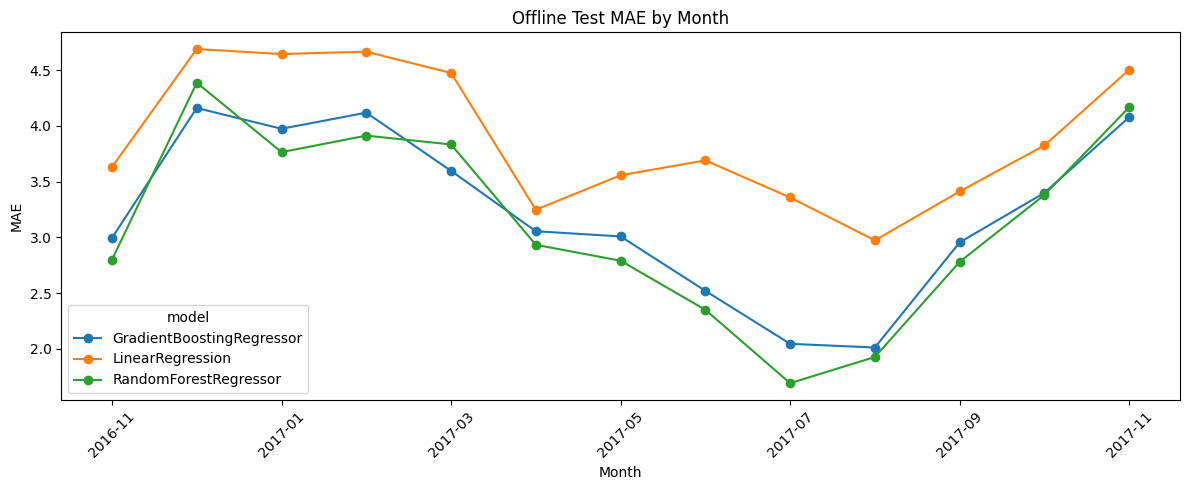

In [16]:
# M4 monthly test metrics table + simple MAE plot
import matplotlib.pyplot as plt

monthly_metric_rows = []

test_eval_base = test_df[[DATETIME_COL]].copy()
test_eval_base["month_period"] = test_eval_base[DATETIME_COL].dt.to_period("M")

for model_name, y_pred in offline_test_predictions.items():
    eval_df = test_eval_base.copy()
    eval_df["y_true"] = y_test.to_numpy()
    eval_df["y_pred"] = y_pred

    for month_period, group in eval_df.groupby("month_period"):
        monthly_metric_rows.append(
            {
                "model": model_name,
                "month": str(month_period),
                "MAE": mean_absolute_error(group["y_true"], group["y_pred"]),
                "RMSE": np.sqrt(mean_squared_error(group["y_true"], group["y_pred"])),
                "R2": r2_score(group["y_true"], group["y_pred"]),
                "n_samples": int(len(group)),
            }
        )

offline_monthly_metrics_df = pd.DataFrame(monthly_metric_rows).sort_values(["month", "model"])

# Simple visual for monthly MAE shifts
pivot_mae = offline_monthly_metrics_df.pivot(index="month", columns="model", values="MAE")
ax = pivot_mae.plot(figsize=(12, 5), marker="o")
ax.set_title("Offline Test MAE by Month")
ax.set_xlabel("Month")
ax.set_ylabel("MAE")
plt.xticks(rotation=45)
plt.tight_layout()

offline_monthly_metrics_df.head(18)

## Optional: TimeSeriesSplit Cross-Validation (Marked Optional)

The next cell is optional and disabled by default. It runs `TimeSeriesSplit` CV for one baseline model to provide an additional time-aware validation signal.

In [20]:
# Optional M4 CV block (kept off by default)
from sklearn.model_selection import TimeSeriesSplit, cross_validate

RUN_OPTIONAL_TSCV = False
optional_tscv_results_df = None

if RUN_OPTIONAL_TSCV:
    tscv_df = offline_df.sort_values(DATETIME_COL).copy()
    X_tscv = tscv_df[feature_columns]
    y_tscv = tscv_df[TARGET_COL]

    tscv_pipeline = Pipeline(
        steps=[
            ("preprocess", preprocessor_offline),
            ("model", LinearRegression()),
        ]
    )

    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = cross_validate(
        tscv_pipeline,
        X_tscv,
        y_tscv,
        cv=tscv,
        scoring={
            "mae": "neg_mean_absolute_error",
            "rmse": "neg_root_mean_squared_error",
            "r2": "r2",
        },
        n_jobs=-1,
        return_train_score=False,
    )

    optional_tscv_results_df = pd.DataFrame(
        {
            "split": np.arange(1, len(cv_scores["test_mae"]) + 1),
            "MAE": -cv_scores["test_mae"],
            "RMSE": -cv_scores["test_rmse"],
            "R2": cv_scores["test_r2"],
        }
    )

optional_tscv_results_df

# Online (Stream) Learning

This section implements **M5** with River using strict chronological progressive validation:

For each sample in time order:
1. predict
2. update metrics
3. `learn_one`

The pipeline is integrated (preprocessing + model), and we track both cumulative and rolling-window metrics for later drift analysis.

In [24]:
# M5 setup: River imports, stream dataframe, and integrated pipelines
from collections import deque
from river import compose, preprocessing as rpp, linear_model as rlm, tree as rtree, metrics as rmetrics

# Keep stream strictly chronological and include datetime for checkpoint timestamps
stream_df = prepared_df.sort_values(["datetime", "city"]).reset_index(drop=True).copy()

# Rolling window choice: about one month of hourly records across 36 cities
# 24 hours * 30 days * 36 cities = 25,920 samples
ROLLING_WINDOW_SIZE = 24 * 30 * 36
CHECKPOINT_EVERY = 5000

river_numeric_features = numeric_features
river_categorical_features = categorical_features

def _round_floats(x, digits=1):
    """Round float values to limit unique values seen by tree splitters (avoids RecursionError in EBST)."""
    return {k: (round(v, digits) if isinstance(v, float) else v) for k, v in x.items()}

def build_river_preprocessor():
    num_pipe = (
        compose.Select(*river_numeric_features)
        | rpp.StatImputer()
        | rpp.StandardScaler()
        | compose.FuncTransformer(lambda x: _round_floats(x, digits=1))
    )
    cat_pipe = (
        compose.Select(*river_categorical_features)
        | rpp.StatImputer()
        | rpp.OneHotEncoder()
    )
    return num_pipe + cat_pipe

# TEBSTSplitter(digits=1) caps unique split points. We also round pipeline outputs above so the
# tree never sees high-precision floats from StandardScaler/StatImputer (avoids deep EBST → RecursionError).
_splitter = lambda: rtree.splitter.TEBSTSplitter(digits=1)

online_models = {
    "RiverLinearRegression": build_river_preprocessor() | rlm.LinearRegression(),
    "HoeffdingTreeRegressor": build_river_preprocessor() | rtree.HoeffdingTreeRegressor(
        grace_period=200,
        leaf_prediction="adaptive",
        splitter=_splitter(),
    ),
    "HoeffdingAdaptiveTreeRegressor": build_river_preprocessor() | rtree.HoeffdingAdaptiveTreeRegressor(
        grace_period=200,
        leaf_prediction="adaptive",
        splitter=_splitter(),
    ),
}

stream_df[["datetime", "city", "temperature"]].head()

,datetime,city,temperature
0,2012-10-01 12:00:00,Eilat,35.95
1,2012-10-01 13:00:00,Albuquerque,11.97
2,2012-10-01 13:00:00,Atlanta,20.88
3,2012-10-01 13:00:00,Beersheba,34.44
4,2012-10-01 13:00:00,Boston,14.02


## Progressive Validation, Cumulative Metrics, and Rolling Metrics

Implementation details:
- **Cumulative metrics** (MAE, RMSE, R2) are updated at each sample.
- **Rolling metrics** are computed from a fixed deque window to highlight local performance changes.
- **Periodic checkpoints** (every `CHECKPOINT_EVERY` samples) store timestamp + cumulative + rolling metrics for later comparison and plotting.

Artifacts retained for later milestones:
- `online_final_metrics_df`
- `online_checkpoints_df`
- `offline_overall_results_df`
- `offline_monthly_metrics_df`

In [ ]:

# M5 core: run progressive validation for each online model and store artifacts
import sys
sys.setrecursionlimit(10000)  # Hoeffding tree splitter evaluation can recurse deeply; avoid RecursionError

def _to_plain_feature_dict(x):
    """Copy feature dict and convert values to plain Python types to avoid RecursionError in River tree (deepcopy)."""
    out = {}
    for k, v in x.items():
        if hasattr(v, "item") and getattr(v, "ndim", 1) == 0:
            out[k] = float(v) if np.issubdtype(type(v), np.floating) else int(v)
        elif isinstance(v, (np.floating, np.integer)):
            out[k] = float(v) if np.issubdtype(type(v), np.floating) else int(v)
        elif isinstance(v, (int, float, str)):
            out[k] = v
        elif pd.isna(v):
            out[k] = None
        else:
            out[k] = v
    return out


def iter_stream_rows(df, feature_cols, target_col, datetime_col):
    for row in df.itertuples(index=False):
        row_dict = row._asdict()
        x = {c: row_dict[c] for c in feature_cols}
        y = row_dict[target_col]
        ts = row_dict[datetime_col]
        yield x, y, ts


def compute_rolling_metrics(y_true_window, y_pred_window):
    y_true_arr = np.array(y_true_window, dtype=float)
    y_pred_arr = np.array(y_pred_window, dtype=float)

    mae_val = float(np.mean(np.abs(y_true_arr - y_pred_arr)))
    rmse_val = float(np.sqrt(np.mean((y_true_arr - y_pred_arr) ** 2)))

    # R2 on rolling window; guard for constant target windows
    denom = float(np.sum((y_true_arr - np.mean(y_true_arr)) ** 2))
    if denom == 0:
        r2_val = np.nan
    else:
        r2_val = float(1 - (np.sum((y_true_arr - y_pred_arr) ** 2) / denom))

    return mae_val, rmse_val, r2_val


online_final_rows = []
online_checkpoint_rows = []

stream_feature_columns = feature_columns

for model_name, model in online_models.items():
    mae_metric = rmetrics.MAE()
    rmse_metric = rmetrics.RMSE()
    r2_metric = rmetrics.R2()

    y_true_window = deque(maxlen=ROLLING_WINDOW_SIZE)
    y_pred_window = deque(maxlen=ROLLING_WINDOW_SIZE)

    running_target_mean = None
    seen_count = 0

    for step, (x, y, ts) in enumerate(
        iter_stream_rows(stream_df, stream_feature_columns, TARGET_COL, DATETIME_COL), start=1
    ):
        x = _to_plain_feature_dict(x)
        y = float(y)
        if np.isnan(y):
            continue

        y_pred = model.predict_one(x)
        if y_pred is None:
            y_pred = float(running_target_mean) if running_target_mean is not None else y
        else:
            y_pred = float(y_pred)
        if np.isnan(y_pred):
            y_pred = float(running_target_mean) if running_target_mean is not None else y

        mae_metric.update(y, y_pred)
        rmse_metric.update(y, y_pred)
        r2_metric.update(y, y_pred)

        y_true_window.append(y)
        y_pred_window.append(y_pred)

        model.learn_one(x, y)

        seen_count += 1
        if running_target_mean is None:
            running_target_mean = y
        else:
            running_target_mean += (y - running_target_mean) / seen_count

        if (step % CHECKPOINT_EVERY == 0) or (step == len(stream_df)):
            if len(y_true_window) > 1:
                r_mae, r_rmse, r_r2 = compute_rolling_metrics(y_true_window, y_pred_window)
            else:
                r_mae, r_rmse, r_r2 = np.nan, np.nan, np.nan

            online_checkpoint_rows.append(
                {
                    "model": model_name,
                    "step": step,
                    "timestamp": ts,
                    "cum_MAE": float(mae_metric.get()),
                    "cum_RMSE": float(rmse_metric.get()),
                    "cum_R2": float(r2_metric.get()),
                    "rolling_MAE": r_mae,
                    "rolling_RMSE": r_rmse,
                    "rolling_R2": r_r2,
                    "rolling_window_size": int(len(y_true_window)),
                }
            )

    online_final_rows.append(
        {
            "model": model_name,
            "samples_seen": len(stream_df),
            "final_cum_MAE": float(mae_metric.get()),
            "final_cum_RMSE": float(rmse_metric.get()),
            "final_cum_R2": float(r2_metric.get()),
            "rolling_window_size_config": ROLLING_WINDOW_SIZE,
            "checkpoint_every": CHECKPOINT_EVERY,
        }
    )

online_final_metrics_df = pd.DataFrame(online_final_rows).sort_values("final_cum_MAE")
online_checkpoints_df = pd.DataFrame(online_checkpoint_rows).sort_values(["model", "step"])

online_final_metrics_df

,model,samples_seen,final_cum_MAE,final_cum_RMSE,final_cum_R2,rolling_window_size_config,checkpoint_every
1,HoeffdingTreeRegressor,1629073,8.413595,10.340359,-0.000018,25920,5000
2,HoeffdingAdaptiveTreeRegressor,1629073,8.413608,10.340364,-0.000019,25920,5000
0,RiverLinearRegression,1629073,8.413621,10.340423,-0.000030,25920,5000


## M4/M5 Output Tables for Later Comparison

The next cell exposes all artifacts created in M4 and M5, ready for later milestones (M6+):

- offline overall metrics
- offline monthly metrics
- online final cumulative metrics
- online periodic checkpoints (cumulative + rolling)

No concept-drift detector logic is implemented here to keep scope limited to M4 and M5.

In [ ]:
# Final M4/M5 artifacts preview
print("Offline overall results:")
display(offline_overall_results_df)

print("Offline monthly metrics (head):")
display(offline_monthly_metrics_df.head(24))

print("Online final cumulative metrics:")
display(online_final_metrics_df)

print("Online checkpoints (head):")
display(online_checkpoints_df.head(20))

artifacts_for_next_milestones = {
    "offline_overall_results_df": offline_overall_results_df,
    "offline_monthly_metrics_df": offline_monthly_metrics_df,
    "online_final_metrics_df": online_final_metrics_df,
    "online_checkpoints_df": online_checkpoints_df,
}

list(artifacts_for_next_milestones.keys())

Offline overall results:


,model,split_timestamp,train_rows,test_rows,MAE,RMSE,R2
1,RandomForestRegressor,2016-11-17 22:00:00,1303273,325800,3.150518,4.286755,0.81823
2,GradientBoostingRegressor,2016-11-17 22:00:00,1303273,325800,3.199282,4.183758,0.82686
0,LinearRegression,2016-11-17 22:00:00,1303273,325800,3.905956,4.948491,0.75778


Offline monthly metrics (head):


,model,month,MAE,RMSE,R2,n_samples
26,GradientBoostingRegressor,2016-11,3.000475,3.841027,0.747378,11268
0,LinearRegression,2016-11,3.641997,4.571547,0.642148,11268
13,RandomForestRegressor,2016-11,2.844637,3.736818,0.760899,11268
27,GradientBoostingRegressor,2016-12,4.142900,5.398205,0.631866,26784
1,LinearRegression,2016-12,4.704922,6.169699,0.519121,26784
14,RandomForestRegressor,2016-12,4.404346,5.834506,0.569953,26784
28,GradientBoostingRegressor,2017-01,3.930801,4.895098,0.686025,26784
2,LinearRegression,2017-01,4.644700,5.864915,0.549291,26784
15,RandomForestRegressor,2017-01,3.756460,4.854807,0.691172,26784
29,GradientBoostingRegressor,2017-02,4.087717,5.203820,0.618793,24192


Online final cumulative metrics:


,model,samples_seen,final_cum_MAE,final_cum_RMSE,final_cum_R2,rolling_window_size_config,checkpoint_every
0,RiverLinearRegression,1629073,NaN,NaN,NaN,25920,5000
1,HoeffdingTreeRegressor,1629073,NaN,NaN,NaN,25920,5000
2,HoeffdingAdaptiveTreeRegressor,1629073,NaN,NaN,NaN,25920,5000


Online checkpoints (head):


,model,step,timestamp,cum_MAE,cum_RMSE,cum_R2,rolling_MAE,rolling_RMSE,rolling_R2,rolling_window_size
652,HoeffdingAdaptiveTreeRegressor,5000,2012-10-07 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,5000
653,HoeffdingAdaptiveTreeRegressor,10000,2012-10-13 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,10000
654,HoeffdingAdaptiveTreeRegressor,15000,2012-10-18 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,15000
655,HoeffdingAdaptiveTreeRegressor,20000,2012-10-24 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,20000
656,HoeffdingAdaptiveTreeRegressor,25000,2012-10-30 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,25000
657,HoeffdingAdaptiveTreeRegressor,30000,2012-11-05 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,25920
658,HoeffdingAdaptiveTreeRegressor,35000,2012-11-11 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,25920
659,HoeffdingAdaptiveTreeRegressor,40000,2012-11-16 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,25920
660,HoeffdingAdaptiveTreeRegressor,45000,2012-11-22 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,25920
661,HoeffdingAdaptiveTreeRegressor,50000,2012-11-28 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,25920


['offline_overall_results_df',
 'offline_monthly_metrics_df',
 'online_final_metrics_df',
 'online_checkpoints_df']